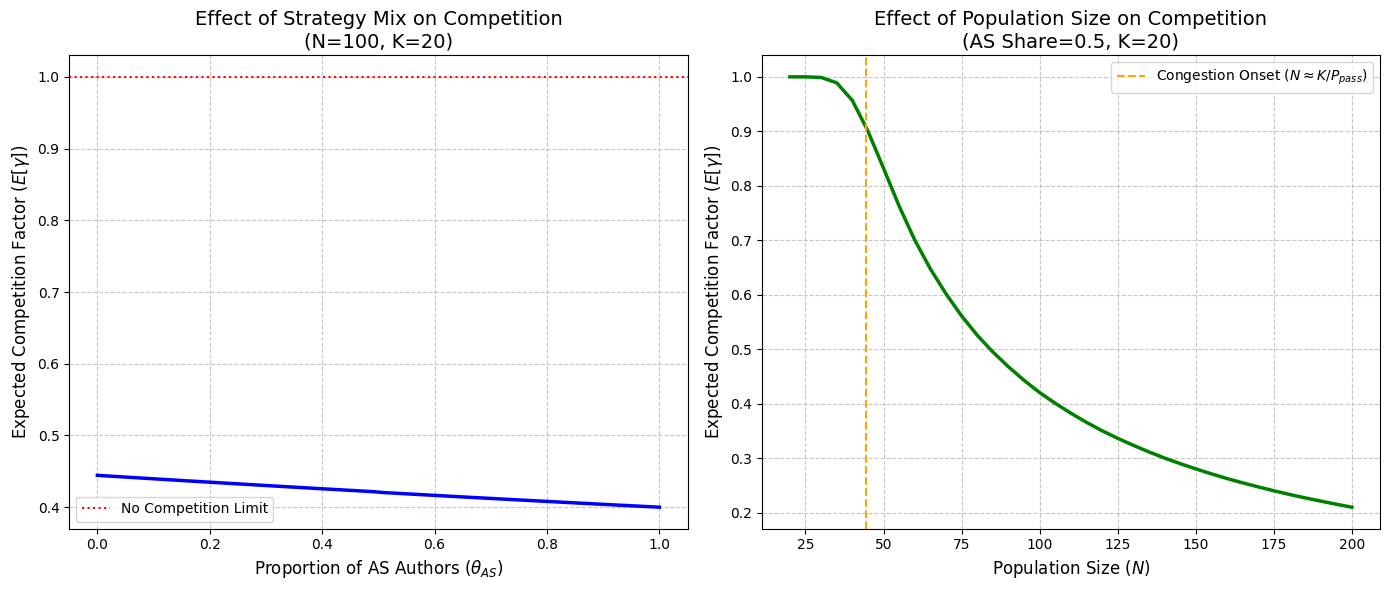

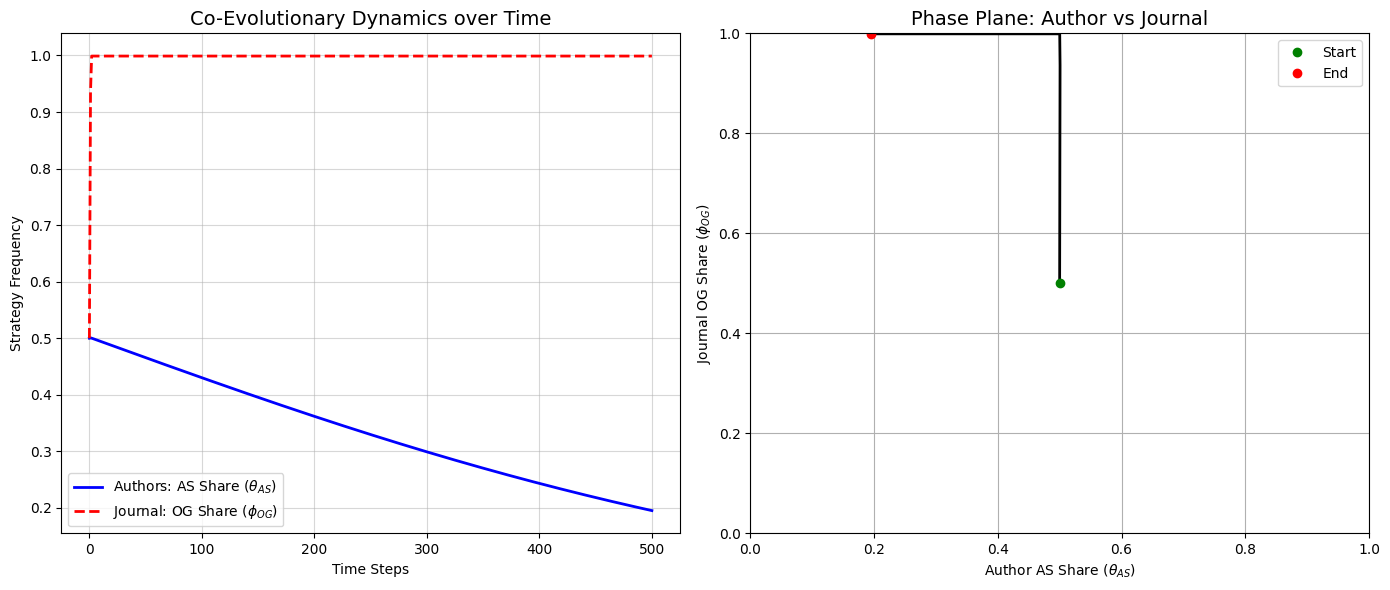

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

class ThresholdGame:
    def __init__(self, N=100, K=20, r=1.0, c=0.1, B=1.0, D=3.0,
                 alpha=0.5, epsilon=0.1, lam=0.1):
        self.N = int(N)
        self.K = int(K)
        self.r = r
        self.c = c
        self.B = B
        self.D = D
        self.alpha = alpha
        self.epsilon = epsilon
        self.lam = lam

    def _calculate_expected_gamma(self, theta_AS_others):

        N_others = self.N - 1


        p_pass_OG = self.alpha * (1 - self.epsilon)
        p_pass_AS = self.alpha * (1 - self.epsilon) + (1 - self.alpha) * self.lam


        n_as = int(np.round(N_others * theta_AS_others))
        n_og = N_others - n_as


        if n_og > 0:
            pmf_og = binom.pmf(np.arange(n_og + 1), n_og, p_pass_OG)
        else:
            pmf_og = np.array([1.0])

        if n_as > 0:
            pmf_as = binom.pmf(np.arange(n_as + 1), n_as, p_pass_AS)
        else:
            pmf_as = np.array([1.0])


        pmf_m = np.convolve(pmf_og, pmf_as)


        m_vals = np.arange(len(pmf_m))
        gamma_vals = np.minimum(1.0, self.K / (1.0 + m_vals))

        return np.sum(pmf_m * gamma_vals)

    def get_payoffs(self, theta_AS, phi_OG):

        gamma_OG = self._calculate_expected_gamma(theta_AS)


        u_OG_vs_OG = self.alpha * ((1 - self.epsilon) * gamma_OG * self.r - self.c)

        p_pass_AS = self.alpha * (1 - self.epsilon) + (1 - self.alpha) * self.lam
        u_AS_vs_OG = p_pass_AS * gamma_OG * self.r - self.c


        total_sub = (1 - theta_AS) * self.alpha + theta_AS * 1.0
        prob_AA = min(1.0, self.K / (self.N * total_sub))

        u_OG_vs_AA = self.alpha * (prob_AA * self.r - self.c)
        u_AS_vs_AA = 1.0 * (prob_AA * self.r - self.c)


        u_AS = phi_OG * u_AS_vs_OG + (1 - phi_OG) * u_AS_vs_AA
        u_OG = phi_OG * u_OG_vs_OG + (1 - phi_OG) * u_OG_vs_AA


        rate_good_pool = ((1-theta_AS)*self.alpha*(1-self.epsilon) + theta_AS*self.alpha*(1-self.epsilon))
        rate_bad_pool  = theta_AS*(1-self.alpha)*self.lam


        cost_base = 0.05 * self.N

        u_J_OG = (self.B * rate_good_pool * self.N - self.D * rate_bad_pool * self.N) * gamma_OG - cost_base


        rate_good_sub = ((1-theta_AS)*self.alpha + theta_AS*self.alpha)
        rate_bad_sub  = theta_AS*(1-self.alpha)

        u_J_AA = (self.B * rate_good_sub * self.N - self.D * rate_bad_sub * self.N) * prob_AA - 0 # AA无审稿成本

        return u_AS, u_OG, u_J_OG, u_J_AA



N_fixed = 100
K_val = 20
alpha_val = 0.5
game_static = ThresholdGame(N=N_fixed, K=K_val, alpha=alpha_val)

# Data 1: Gamma vs Theta
theta_list = np.linspace(0, 1, 50)
gamma_vs_theta = [game_static._calculate_expected_gamma(t) for t in theta_list]

# Data 2: Gamma vs N
theta_fixed = 0.5
N_list = np.arange(20, 201, 5)
gamma_vs_N = []
for n in N_list:
    g_temp = ThresholdGame(N=n, K=K_val, alpha=alpha_val)._calculate_expected_gamma(theta_fixed)
    gamma_vs_N.append(g_temp)

# Plotting Figure 1
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(theta_list, gamma_vs_theta, 'b-', linewidth=2.5)
plt.title(f'Effect of Strategy Mix on Competition\n(N={N_fixed}, K={K_val})', fontsize=14)
plt.xlabel(r'Proportion of AS Authors ($\theta_{AS}$)', fontsize=12)
plt.ylabel(r'Expected Competition Factor ($E[\gamma]$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=1.0, color='r', linestyle=':', label='No Competition Limit')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(N_list, gamma_vs_N, 'g-', linewidth=2.5)
plt.title(f'Effect of Population Size on Competition\n(AS Share=0.5, K={K_val})', fontsize=14)
plt.xlabel(r'Population Size ($N$)', fontsize=12)
plt.ylabel(r'Expected Competition Factor ($E[\gamma]$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

p_pass_approx = alpha_val * 0.9
plt.axvline(x=K_val/p_pass_approx, color='orange', linestyle='--', label=r'Congestion Onset ($N \approx K/P_{pass}$)')
plt.legend()

plt.tight_layout()
plt.show()



def run_coevolution(steps=500, dt=0.1):
    game = ThresholdGame(N=100, K=20, D=3.0) # High Penalty for bad papers


    theta_AS = 0.5
    phi_OG = 0.5

    history_theta = [theta_AS]
    history_phi = [phi_OG]

    for _ in range(steps):
        u_AS, u_OG, u_J_OG, u_J_AA = game.get_payoffs(theta_AS, phi_OG)

        # Author Dynamics
        avg_A = theta_AS * u_AS + (1 - theta_AS) * u_OG
        d_theta = theta_AS * (u_AS - avg_A)

        # Journal Dynamics
        avg_J = phi_OG * u_J_OG + (1 - phi_OG) * u_J_AA
        d_phi = phi_OG * (u_J_OG - avg_J)

        # Update
        theta_AS += d_theta * dt
        phi_OG += d_phi * dt

        # Clip
        theta_AS = np.clip(theta_AS, 0.001, 0.999)
        phi_OG = np.clip(phi_OG, 0.001, 0.999)

        history_theta.append(theta_AS)
        history_phi.append(phi_OG)

    return history_theta, history_phi

# Run Simulation
traj_theta, traj_phi = run_coevolution()

# Plotting Figure 2
plt.figure(figsize=(14, 6))

# Time Series
plt.subplot(1, 2, 1)
plt.plot(traj_theta, label=r'Authors: AS Share ($\theta_{AS}$)', color='blue', linewidth=2)
plt.plot(traj_phi, label=r'Journal: OG Share ($\phi_{OG}$)', color='red', linewidth=2, linestyle='--')
plt.title('Co-Evolutionary Dynamics over Time', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Strategy Frequency')
plt.legend()
plt.grid(True, alpha=0.5)

# Phase Plane
plt.subplot(1, 2, 2)
plt.plot(traj_theta, traj_phi, 'k-', linewidth=2)
plt.plot(traj_theta[0], traj_phi[0], 'go', label='Start')
plt.plot(traj_theta[-1], traj_phi[-1], 'ro', label='End')
plt.title('Phase Plane: Author vs Journal', fontsize=14)
plt.xlabel(r'Author AS Share ($\theta_{AS}$)')
plt.ylabel(r'Journal OG Share ($\phi_{OG}$)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

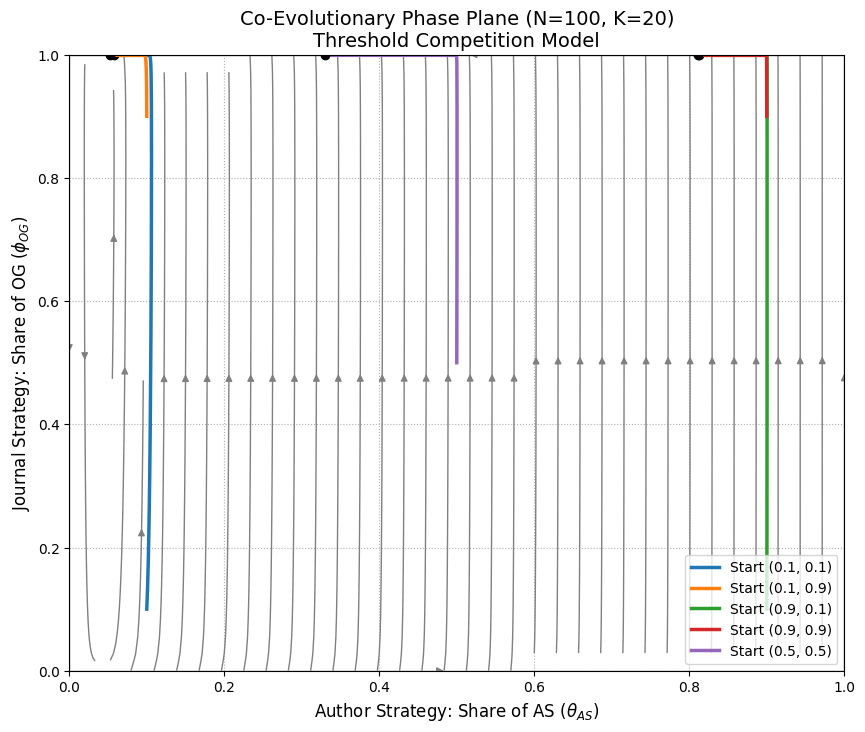

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

class ThresholdGame:
    def __init__(self, N=100, K=20, r=1.0, c=0.1, B=1.0, D=3.0,
                 alpha=0.5, epsilon=0.1, lam=0.1, review_cost_factor=0.05):
        self.N = N
        self.K = K
        self.r = r      # Author reward
        self.c = c      # Author cost
        self.B = B      # Journal benefit for Good
        self.D = D      # Journal penalty for Bad
        self.alpha = alpha
        self.epsilon = epsilon
        self.lam = lam
        self.cost_factor = review_cost_factor # C_fix in thesis

    def _calc_gamma_OG(self, theta_AS):

        N_others = self.N - 1
        p_pass_OG = self.alpha * (1 - self.epsilon)
        p_pass_AS = self.alpha * (1 - self.epsilon) + (1 - self.alpha) * self.lam


        n_as = int(np.round(N_others * theta_AS))
        n_og = N_others - n_as

        pmf_og = binom.pmf(np.arange(n_og + 1), n_og, p_pass_OG) if n_og > 0 else [1.0]
        pmf_as = binom.pmf(np.arange(n_as + 1), n_as, p_pass_AS) if n_as > 0 else [1.0]
        pmf_m = np.convolve(pmf_og, pmf_as)


        m_vals = np.arange(len(pmf_m))
        gamma_vals = np.minimum(1.0, self.K / (1.0 + m_vals))
        return np.sum(pmf_m * gamma_vals)

    def _calc_gamma_AA(self, theta_AS):

        N_others = self.N - 1

        p_sub_OG = self.alpha
        p_sub_AS = 1.0

        n_as = int(np.round(N_others * theta_AS))
        n_og = N_others - n_as

        pmf_og = binom.pmf(np.arange(n_og + 1), n_og, p_sub_OG) if n_og > 0 else [1.0]
        pmf_as = binom.pmf(np.arange(n_as + 1), n_as, p_sub_AS) if n_as > 0 else [1.0]
        pmf_s = np.convolve(pmf_og, pmf_as)


        s_vals = np.arange(len(pmf_s))
        gamma_vals = np.minimum(1.0, self.K / (1.0 + s_vals))
        return np.sum(pmf_s * gamma_vals)

    def get_fitness(self, theta_AS, phi_OG):

        gamma_OG = self._calc_gamma_OG(theta_AS)
        gamma_AA = self._calc_gamma_AA(theta_AS)


        p_pass_AS_OG = self.alpha*(1-self.epsilon) + (1-self.alpha)*self.lam
        u_AS_vs_OG = p_pass_AS_OG * gamma_OG * self.r - self.c
        u_OG_vs_OG = self.alpha * ((1-self.epsilon) * gamma_OG * self.r - self.c)



        u_AS_vs_AA = 1.0 * gamma_AA * self.r - self.c

        u_OG_vs_AA = self.alpha * (1.0 * gamma_AA * self.r - self.c)


        u_AS = phi_OG * u_AS_vs_OG + (1 - phi_OG) * u_AS_vs_AA
        u_OG = phi_OG * u_OG_vs_OG + (1 - phi_OG) * u_OG_vs_AA


        E_S = (1-theta_AS)*self.alpha + theta_AS*1.0

        cost = self.cost_factor * (E_S * self.N)**1.0

        rate_good_pool = ((1-theta_AS)*self.alpha*(1-self.epsilon) + theta_AS*self.alpha*(1-self.epsilon))
        rate_bad_pool  = theta_AS*(1-self.alpha)*self.lam
        total_rate_pool = rate_good_pool + rate_bad_pool


        frac_good = rate_good_pool / total_rate_pool if total_rate_pool > 0 else 0
        frac_bad = rate_bad_pool / total_rate_pool if total_rate_pool > 0 else 0


        exp_acc_good_OG = self.N * rate_good_pool * gamma_OG
        exp_acc_bad_OG  = self.N * rate_bad_pool * gamma_OG

        u_J_OG = self.B * exp_acc_good_OG - self.D * exp_acc_bad_OG - cost


        rate_good_sub = ((1-theta_AS)*self.alpha + theta_AS*self.alpha)
        rate_bad_sub  = theta_AS*(1-self.alpha)


        exp_acc_good_AA = self.N * rate_good_sub * gamma_AA
        exp_acc_bad_AA  = self.N * rate_bad_sub * gamma_AA


        u_J_AA = self.B * exp_acc_good_AA - self.D * exp_acc_bad_AA - 0

        return u_AS, u_OG, u_J_OG, u_J_AA

def run_coevolution(N=100, K=20, steps=1000, dt=0.05):
    game = ThresholdGame(N=N, K=K, D=3.0) # High penalty for bad papers


    theta_AS = 0.5
    phi_OG = 0.5

    traj_theta = [theta_AS]
    traj_phi = [phi_OG]

    for _ in range(steps):
        u_AS, u_OG, u_J_OG, u_J_AA = game.get_fitness(theta_AS, phi_OG)

        # Author Replicator Dynamics
        avg_u_A = theta_AS * u_AS + (1 - theta_AS) * u_OG
        d_theta = theta_AS * (u_AS - avg_u_A)

        # Journal Replicator Dynamics
        avg_u_J = phi_OG * u_J_OG + (1 - phi_OG) * u_J_AA
        d_phi = phi_OG * (u_J_OG - avg_u_J)

        # Update
        theta_AS += d_theta * dt
        phi_OG += d_phi * dt

        # Boundary
        theta_AS = np.clip(theta_AS, 0.001, 0.999)
        phi_OG = np.clip(phi_OG, 0.001, 0.999)

        traj_theta.append(theta_AS)
        traj_phi.append(phi_OG)

    return traj_theta, traj_phi


initial_points = [(0.1, 0.1), (0.1, 0.9), (0.9, 0.1), (0.9, 0.9), (0.5, 0.5)]
N_val = 100
K_val = 20

plt.figure(figsize=(10, 8))


x = np.linspace(0, 1, 15)
y = np.linspace(0, 1, 15)
X, Y = np.meshgrid(x, y)
U = np.zeros_like(X)
V = np.zeros_like(Y)

game_grid = ThresholdGame(N=N_val, K=K_val, D=3.0)

for i in range(len(x)):
    for j in range(len(y)):
        t_as = X[i, j]
        p_og = Y[i, j]
        u_AS, u_OG, u_J_OG, u_J_AA = game_grid.get_fitness(t_as, p_og)

        avg_A = t_as * u_AS + (1-t_as) * u_OG
        avg_J = p_og * u_J_OG + (1-p_og) * u_J_AA

        U[i, j] = t_as * (u_AS - avg_A) # d(Theta_AS)/dt
        V[i, j] = p_og * (u_J_OG - avg_J) # d(Phi_OG)/dt

plt.streamplot(X, Y, U, V, color='gray', linewidth=1, density=1.2)


for t0, p0 in initial_points:

    curr_t, curr_p = t0, p0
    traj_t, traj_p = [curr_t], [curr_p]
    dt = 0.05
    for _ in range(500):
        u_AS, u_OG, u_J_OG, u_J_AA = game_grid.get_fitness(curr_t, curr_p)
        avg_A = curr_t * u_AS + (1 - curr_t) * u_OG
        avg_J = curr_p * u_J_OG + (1 - curr_p) * u_J_AA
        curr_t += curr_t * (u_AS - avg_A) * dt
        curr_p += curr_p * (u_J_OG - avg_J) * dt
        curr_t = np.clip(curr_t, 0.001, 0.999)
        curr_p = np.clip(curr_p, 0.001, 0.999)
        traj_t.append(curr_t)
        traj_p.append(curr_p)

    plt.plot(traj_t, traj_p, linewidth=2.5, label=f'Start ({t0}, {p0})')

    plt.plot(traj_t[-1], traj_p[-1], 'ko')

plt.title(f'Co-Evolutionary Phase Plane (N={N_val}, K={K_val})\nThreshold Competition Model', fontsize=14)
plt.xlabel(r'Author Strategy: Share of AS ($\theta_{AS}$)', fontsize=12)
plt.ylabel(r'Journal Strategy: Share of OG ($\phi_{OG}$)', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle=':')
plt.legend()
plt.show()